## Introduction

Electronic parts distributors like Digi-Key, Mouser etc assign their own internal IDs (known as a SKU, or "stock keeping unit") to every product they sell, which is usually different from the "part number" that manufacturers assign to their own products.

For example, `SN74LVC541APWR` is a part number identifying a particular IC made by Texas Instruments. Digi-Key's assigned SKU for it is `296-8521-1-ND`. Mouser calls it `595-SN74LVC541APWR`.

Once you look at a few examples, you'll notice simple patterns that allow you to (mostly) identify the source of each part number/SKU. If you wanted a computer to do that for you, regular expressions would work. _But that wouldn't be fun, would it?_

This turns out to be a great toy problem to try some machine learning algorithms on. What we want to do is use a whole lot of labeled data (where we already know the answers from some other data source) to build a model that we can then ask to categorize part numbers/SKUs that it hasn't seen before.

~~~
Me: Hey computer, what's "595-SN74LVC541APWR"?
Computer: That looks like a Mouser SKU.
Me: Ok, how about "296-8521-1-ND"?
Computer: Pretty sure it's a Digi-Key SKU.
Me: And what about "the AI is a lie"?
Computer: ...*&$*&^#$.... CRASH
~~~

Since we'll be classifying sequences of characters, something like an [LSTM recurrent neural network](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) should do the trick.

We'll be using a fairly typical machine learning environment: Python, pandas, numpy, Keras and TensorFlow.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.utils import to_categorical

Using TensorFlow backend.


## Training data

Let's start with a simple labeled dataset with 2 columns:
- `partnum` is the part number/SKU string that we'll teach the model to classify
- `class` is the known classification. It has 3 possible values:
  - `0` is a manufacturer's part number
  - `1` is a Mouser SKU
  - `2` is a Digi-Key SKU

Here are the first few rows of our source file:

In [2]:
df_raw = pd.read_csv('data/mpn_mouser_digikey.csv')
df_raw.sample(n=10)

,partnum,class
131,490-5834-1-ND,2
24367,587-1227-1-ND,2
18407,P20449DKR-ND,2
17126,S25FL256SAGNFI001,0
1319,621-SMAJ70CA-13-F,1
13650,296-23881-2-ND,2
8612,798-DF11-4DP-2DSA24,1
3315,700-MAX14824GTG+,1
3383,311-22KGRTR-ND,2
11000,732-11424-6-ND,2


It'd be good to know how many examples of each class we have, to make sure we don't run into issues with [unbalanced training sets](https://www.quora.com/In-classification-how-do-you-handle-an-unbalanced-training-set)

Let's plot how many samples of manufacturer part numbers, Mouser SKUs and Digi-Key SKUs we have in our training set.

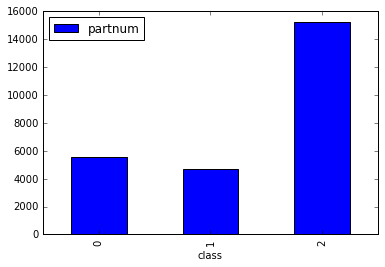

In [18]:
df_raw.groupby('class').count().plot.bar()

Looks like we have a lot more samples of Digi-Key SKUs than others. Let's drop some data to equalize the number of samples in each class.

In [26]:
limit_rows_per_class = int(df_raw.groupby('class').count().min())
limit_rows_per_class

4711